## Reciprocal connections as a metric of complexity 

We analyze reciprocal connection densities across neighborhoods as a measure of network complexity in 

* C. elegans (last stage) of *Witvliet et al:* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8756380/  
* Drosophila larva of *Winding et al., 2023* https://www.science.org/doi/10.1126/science.add9330 
* MICrONS data set of the *IARPA MICrONS mm^3 dataset* https://www.microns-explorer.org/cortical-mm3 
* The V5 version of the Blue Brain Project model of https://www.cell.com/fulltext/S0092-8674(15)01191-5

For easy handling, we use the the conntility package and the code provided in 
https://github.com/BlueBrain/ConnectomeUtilities/blob/main/examples
for loading the three first connectivity matrices 

The data used here was generated using `../code/rc_{connectome}.py` for connectome in `BBP`, `MICrONS`, `Celegans`, `Drosophila`

In [3]:
import pandas as pd 
import numpy as np 
from scipy import stats 
import pickle
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [156]:
# Load precomputed data 
root='/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data/'
connectomes=['BBP','MICrONS', 'Celegans', 'Drosophila']
#connectomes=['MICrONS', 'Celegans', 'Drosophila']
control_labels=['Original', 'ER', "CM", 'Distance']
controls=['original', 'ER_shuffle', "configuration_model", 'run_DD2']
data={conn:{} for conn in connectomes}
for conn in connectomes: 
    gtypes=controls if conn in ['MICrONS', 'BBP'] else controls[:-1]
    for i, gtype in enumerate(gtypes):
        data[conn][control_labels[i]]=pd.read_pickle(f'{root}{conn}_nbd_basics_{gtype}.pkl')

In [138]:
cmap=plt.cm.Dark2
colors={
    'Original':'indianred',#cmap(3), 
    'CM':cmap(2), 
    'ER':cmap(0), 
    'Distance':cmap(1)}

In [180]:
prop="2_simplices"
conn="Drosophila"
df=pd.concat([data[conn][ctr][prop] for ctr in data[conn].keys()], axis=1, keys=list(data[conn].keys()))

In [181]:
ran=np.random.uniform(low=df.min().min(),high=df.max().max(), size=len(df))

<Axes: ylabel='Density'>

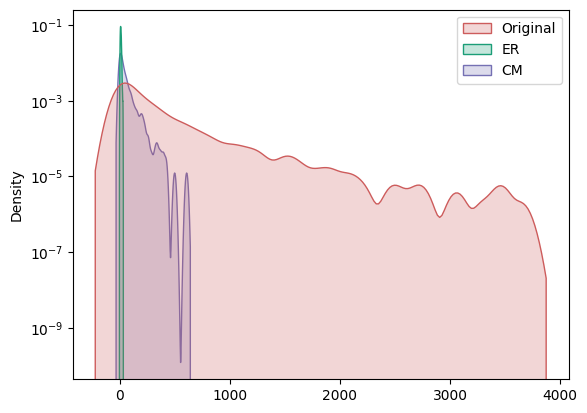

In [183]:
fig,ax=plt.subplots()
#sns.kdeplot(data=df,x="Original", common_norm=False,ax=ax, fill=False, log_scale=(False, False), color=colors["Original"])
#sns.kdeplot(data=df.drop("Original", axis=1), common_norm=False,ax=ax, fill=True, log_scale=(False, False), palette=colors)
sns.kdeplot(data=df, common_norm=False,ax=ax, fill=True, log_scale=(False, True), palette=colors)

In [169]:
df.apply(lambda x: stats.wasserstein_distance(ran, x.fillna(0)), axis=0)

Original    0.403757
ER          0.540875
CM          0.477560
dtype: float64

In [170]:
df.apply(np.std, axis=0)

Original    0.167121
ER          0.007993
CM          0.151941
dtype: float64

<Axes: xlabel='Distance', ylabel='Density'>

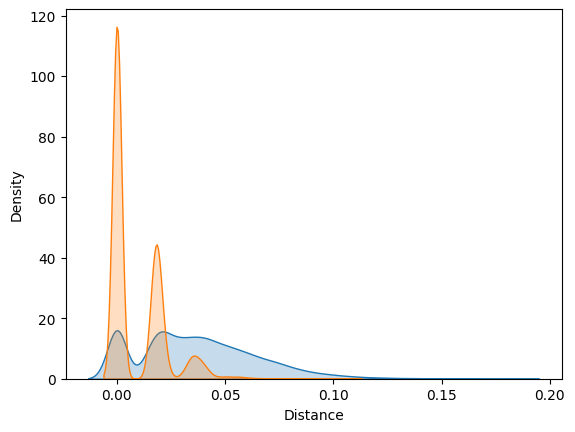

In [123]:
fig,ax=plt.subplots()
#sns.kdeplot(data=df, x="Original", common_norm=False,ax=ax)
sns.kdeplot(data=df, x="Distance", common_norm=False,ax=ax, fill = True)
#sns.kdeplot(data=df, x="CM", common_norm=False,ax=ax)
sns.kdeplot(data=df, x="ER", common_norm=False,ax=ax, fill=True)
#sns.kdeplot(data=pd.Series(ran),ax=ax)
#plt.yscale("log")

<Axes: ylabel='Density'>

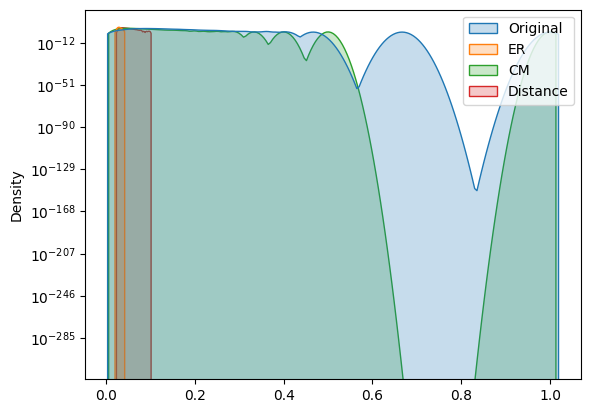

In [136]:
fig,ax=plt.subplots()
sns.kdeplot(data=df, common_norm=False,ax=ax, fill=True, log_scale=(False, True))

<Axes: xlabel='Original', ylabel='Density'>

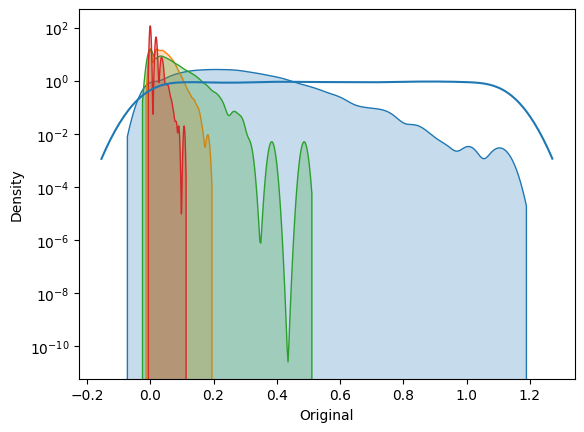

In [133]:
fig,ax=plt.subplots()
sns.kdeplot(data=df, x="Original", common_norm=False,ax=ax, fill=True, log_scale=(False, True))
sns.kdeplot(data=df, x="Distance", common_norm=False,ax=ax, fill=True, log_scale=(False, True))
sns.kdeplot(data=df, x="CM", common_norm=False,ax=ax, fill=True, log_scale=(False, True))
sns.kdeplot(data=df, x="ER", common_norm=False,ax=ax, fill=True, log_scale=(False, True))
sns.kdeplot(data=pd.Series(ran),ax=ax, log_scale=(False, True))
#plt.yscale("log")

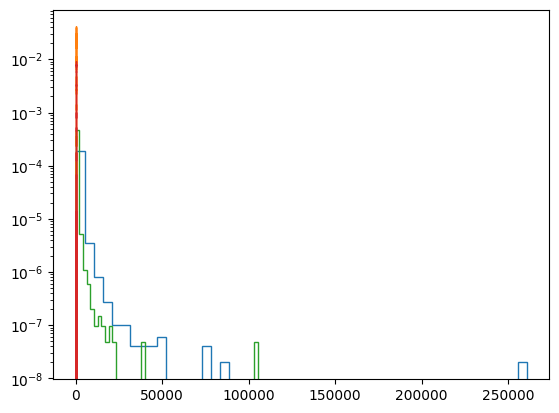

In [179]:
for ctr in data["MICrONS"].keys():
    plt.hist(data["MICrONS"][ctr]["2_simplices"], histtype="step", bins=50, density=True)
plt.yscale("log")

In [ ]:
# Plotting functions 
def kde_and_regress(ax, df, x, y, color):
    x=df[x]; y=df[y] 
    mask=np.logical_and(~np.isnan(y), ~np.isnan(x))
    regress=stats.linregress(x[mask],y[mask])
    ax.plot(x, x*regress.slope+regress.intercept, color=color, label=f"{regress.rvalue:.2f}")
    sns.kdeplot(data=df, x=x, y=y, fill=True, ax=ax, color=color)
    ax.set_ylabel('');     ax.set_xlabel('')
    ax.spines[["right", "top"]].set_visible(False)
    return ax
def kde_ori_single_control(ax, conn, base_prop, complexity_prop, control="ER"):
    axes=[ax]
    base_graph="original"
    kde_and_regress(ax, data[conn][f"df_{base_graph}"],  x=base_prop, y=complexity_prop, color=colors[base_graph])

    
    base_graph=control
    left, bottom, width, height= [0.25, 0.85, .2, 0.2]
    ax0=ax.inset_axes([left, bottom, width, height])
    axes.append(ax0)
    kde_and_regress(ax0, data[conn][f"df_{base_graph}"],  x=base_prop, y=complexity_prop, 
                    color=colors[base_graph])
    
    # Make r-value legend
    legs=[x.get_legend_handles_labels() for x in axes]
    legend=[l[0][0] for l in legs], [l[1][0] for l in legs]

    # Ticksize 
    ax.tick_params(axis='both', labelsize=ticksize)
    ax0.tick_params(axis='both', labelsize=ticksize-2)
    return legend
def plot_outliers(axes, base_prop, q=0.01,
                  props = ['euclidean_edges_sc', 'wasserstein_deg_total'],  base_graph='original'):
    # Organize data into DataFrame for seaborn 
    champs=[]
    for conn in connectomes:
        df=data[conn][f'df_{base_graph}']
        top=df[df[base_prop]>=df.quantile(1-q)[base_prop]][props]
        top["type"]="top"
        bottom=df[df[base_prop]<=df.quantile(q)[base_prop]][props]
        bottom["type"]="bottom"
        tb=pd.concat([top, bottom])
        tb["connectome"]=conn
        champs.append(tb)
    champs=pd.concat(champs)
    for i, prop in enumerate(props):
        sns.violinplot(champs, x="connectome", y=prop, hue="type",ax=axes[i], split=True, 
                   palette=colors, inner="quartile", saturation=0.5, linewidth=0.5)

# Font sizes and color and marker schemes
titlesize=8
labelsize=6
ticksize=6
marker_size=2
conversion=2.54
#conversion=1.5
scatter_kws={'alpha':0.1, 's':2}

cmap=plt.cm.Dark2
colors={
    'original':'indianred',#cmap(3), 
    'CM':cmap(2), 
    'ER':cmap(0), 
    'distance':cmap(1)}

In [ ]:
width=21*0.8/conversion
rows, cols = 2, 4
base_prop='rc_over_nodes'#'rc_over_edges'
complexity_prop='wasserstein_deg_total'#'euclidean_edges_sc'
fig, axs =plt.subplots(rows,cols,figsize=(width, width*rows*1.1/cols))

# Distances to CM 
for i, complexity_prop in enumerate(['wasserstein_deg_total', 'euclidean_edges_sc']):
    for j, conn in enumerate(connectomes):
        control="ER"
        legend = kde_ori_single_control(axs[i,j], conn, base_prop, complexity_prop, control=control)
        handles = [mlines.Line2D([], [], color=colors[base_graph], marker='o', linestyle='None',markersize=2)
               for base_graph in ['original']+[control]]
        axs[i,j].legend(handles, legend[1], title="r-values:", frameon=False, loc=4, 
                      fontsize=labelsize,title_fontsize=ticksize)
        axs[-1,j].set_xlabel("Reciprocal density", fontsize=labelsize)
        axs[0,j].set_title(f"{conn}", fontsize=titlesize)

    
axs[0,0].set_ylabel("Neighborhood complexity \n(degree)", fontsize=labelsize)
axs[1,0].set_ylabel("Neighborhood complexity \n(simplicial)", fontsize=labelsize)
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)

# Creating legend with color box
color_box = [mpatches.Patch(color=colors[base_graph], label=f'{base_graph}', linewidth=1, alpha=1) 
             for base_graph in ['original']+[control]]
             
fig.legend(handles=color_box, bbox_to_anchor=[0.6,0], frameon=False, fontsize=labelsize, ncols=3)

fig.savefig("figs/rc_complexity_all_connectomes_kde.pdf", transparent=True, bbox_inches='tight')